Montserrat Guadalupe Flores Flores 2055196 N5

Dylan Yahir Salazar Guardiola 2044839 N4

Joel Homero Venegas Cano 1996795 N4

Cristian Daniel Lucio Jiménez 1994502 N4

# **Producto Integrador de Aprendizaje de la clase Inteligencia Artificial y Redes Neuronales**

## **Introducción**

Este proyecto consiste en el entrenamiento de una red neuronal convolucional para la clasificación de 3 tipos de tuercas (con arandela, hexagonal y hexagonal ciega), se creó un dataset con estas tres clases y las imágenes en formato .jpg comparten las mismas dimensiones

## **Dataset**

Ya que nuestro dataset es una carpeta con subcarpetas almacenada localmente, vamos a cargarlo en Colab en formato .zip y descomprimir

In [1]:
from google.colab import files
uploaded = files.upload()
!unzip -q dataset.zip -d ./
!ls dataset

Saving dataset.zip to dataset.zip
con_arandela  hexagonal  hexagonal_ciega


## **Librerías**

La primera parte consiste en importar las librerías

In [2]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, applications, callbacks, optimizers,regularizers  # type: ignore
from tensorflow.keras import callbacks # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from sklearn.utils import class_weight

## **Preprocesamiento**

En esta sección se configuran los parámetros (tamaño de imagen, ruta, proporción de test y épocas), se cargan todas las imágenes y etiquetas desde las tres carpetas en un solo tf.data.Dataset, se divide en conjuntos de entrenamiento y prueba manteniendo la proporción de clases y se normalizan los píxeles. Es decir en esta sección tenemos la configuración y generadores de datos.


In [23]:
## ------------------- CONFIGURACIÓN -------------------
DATASET_PATH = "/content/dataset"
IMG_SIZE = (224, 224)  # Tamaño
BATCH_SIZE = 32
EPOCHS = 40  # Épocas totales (incluyendo fine-tuning)


In [15]:
## ------------------- GENERADORES DE DATOS -------------------
# Aumento de datos mejorado (sin excederse)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=20.0,
    fill_mode='reflect',
    validation_split=0.15
)

# Generadores
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)
class_names = list(train_generator.class_indices.keys())

Found 540 images belonging to 3 classes.
Found 93 images belonging to 3 classes.


## **Estructura y entrenamiento de Red Neuronal Artificial Convolusional (RNAC)**

En esta sección se establece la arquitectura de nuestra red neuronal artificial convolucional. Se hace uso de Transfer Learning para mejorar eficiencia y precisión

In [5]:
## ------------------- MODELO MOBILENETV2 MEJORADO -------------------
# Cargar modelo base CONGELADO
base_model = applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Congelar inicialmente


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Arquitectura mejorada
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.Dropout(0.4),  # Dropout aumentado
    layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='swish'),
    layers.Dense(3, activation='softmax')  # Cambiar '3' por tu número de clases
])


In [7]:
# Compilación inicial
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
## ------------------- CALLBACKS AVANZADOS -------------------
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001,
    mode='max'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)


Entrenamiento

In [9]:
## ------------------- ENTRENAMIENTO EN 2 FASES -------------------
# FASE 1: Entrenar solo las capas nuevas
print("\n>>> FASE 1: Entrenamiento inicial")
history1 = model.fit(
    train_generator,
    epochs=20,  # Primera fase más corta
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# FASE 2: Fine-tuning (descongelar capas superiores)
print("\n>>> FASE 2: Fine-tuning")
base_model.trainable = True
for layer in base_model.layers[:-40]:  # Descongelar solo últimas 40 capas
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # LR más bajo
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


>>> FASE 1: Entrenamiento inicial


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4182 - loss: 1.6572

17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4180 - loss: 1.6561 - val_accuracy: 0.5161 - val_loss: 1.4123 - learning_rate: 1.0000e-04
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5081 - loss: 1.4049

17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5109 - loss: 1.4018 - val_accuracy: 0.6022 - val_loss: 1.3098 - learning_rate: 1.0000e-04
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5935 - loss: 1.3087

17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5943 - loss: 1.3085 - val_accuracy: 0.6774 - val_loss: 1.2536 - learning_rate: 1.0000e-04
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6646 - loss: 1.1942 - val_accuracy: 0.6667 - val_loss: 1.2157 - learning_rate: 1.0000e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7255 - loss: 1.0797

17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7262 - loss: 1.0789 - val_accuracy: 0.7312 - val_loss: 1.1436 - learning_rate: 1.0000e-04
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7477 - loss: 1.0811 - val_accuracy: 0.6667 - val_loss: 1.1618 - learning_rate: 1.0000e-04
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7985 - loss: 0.9471 - val_accuracy: 0.7312 - val_loss: 1.0768 - learning_rate: 1.0000e-04
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7825 - loss: 0.9500

17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7839 - loss: 0.9474 - val_accuracy: 0.7634 - val_loss: 1.0670 - learning_rate: 1.0000e-04
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8548 - loss: 0.8508 - val_accuracy: 0.7527 - val_loss: 1.0392 - learning_rate: 1.0000e-04
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8281 - loss: 0.8764 - val_accuracy: 0.6882 - val_loss: 1.0327 - learning_rate: 1.0000e-04
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8633 - loss: 0.8196 - val_accuracy: 0.7204 - val_loss: 1.0093 - learning_rate: 1.0000e-04
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8179 - loss: 0.8597 - val_accuracy: 0.7312 - val_loss: 0.9894 - learning_rate: 1.0000e-04
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8626 - loss: 0.7786

17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8627 - loss: 0.7797 - val_accuracy: 0.7849 - val_loss: 0.9888 - learning_rate: 1.0000e-04
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8676 - loss: 0.7717 - val_accuracy: 0.7634 - val_loss: 0.9651 - learning_rate: 1.0000e-04
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8457 - loss: 0.8084 - val_accuracy: 0.7527 - val_loss: 0.9725 - learning_rate: 1.0000e-04
Epoch 16/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8706 - loss: 0.7902 - val_accuracy: 0.7849 - val_loss: 0.9389 - learning_rate: 1.0000e-04
Epoch 17/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8749 - loss: 0.7467 - val_accuracy: 0.7527 - val_loss: 0.9372 - learning_rate: 1.0000e-04
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8846 - loss: 0.7354

17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8848 - loss: 0.7343 - val_accuracy: 0.8172 - val_loss: 0.9336 - learning_rate: 1.0000e-04
Epoch 19/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9097 - loss: 0.6811 - val_accuracy: 0.7634 - val_loss: 0.9332 - learning_rate: 1.0000e-04
Epoch 20/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8889 - loss: 0.7147 - val_accuracy: 0.7634 - val_loss: 0.9180 - learning_rate: 1.0000e-04

>>> FASE 2: Fine-tuning


In [10]:
history2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    initial_epoch=history1.epoch[-1] + 1,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 21/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7151 - loss: 1.0460

17/17 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7173 - loss: 1.0427 - val_accuracy: 0.8280 - val_loss: 0.9082 - learning_rate: 1.0000e-05
Epoch 22/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7642 - loss: 0.9639 - val_accuracy: 0.7097 - val_loss: 0.9828 - learning_rate: 1.0000e-05
Epoch 23/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7885 - loss: 0.8857 - val_accuracy: 0.7634 - val_loss: 0.9737 - learning_rate: 1.0000e-05
Epoch 24/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8910 - loss: 0.8024
Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8898 - loss: 0.8039 - val_accuracy: 0.7527 - val_loss: 1.0007 - learning_rate: 1.0000e-05
Epoch 25/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8151 - loss: 0.8712 - val_accuracy: 0.6989 - val_loss: 1.0562 - learning_rate: 5.0000e-06
Epoch 26/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8431 - loss: 0.8179 - v

## **Resultados de exactitud de la RNAC**

En esta sección se muestran los resultados del entrenamiento de la red neuronal convolucional con Transfer Learning

In [11]:
## ------------------- EVALUACIÓN FINAL -------------------
# Cargar el mejor modelo guardado
best_model = tf.keras.models.load_model('best_model.h5')

# Generador de test (sin aumentos)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)

Found 633 images belonging to 3 classes.


In [12]:
# Evaluación estándar
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\nPrecisión en Test: {test_acc*100:.2f}%")

633/633 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.8629 - loss: 0.7540

Precisión en Test: 92.10%


633/633 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step


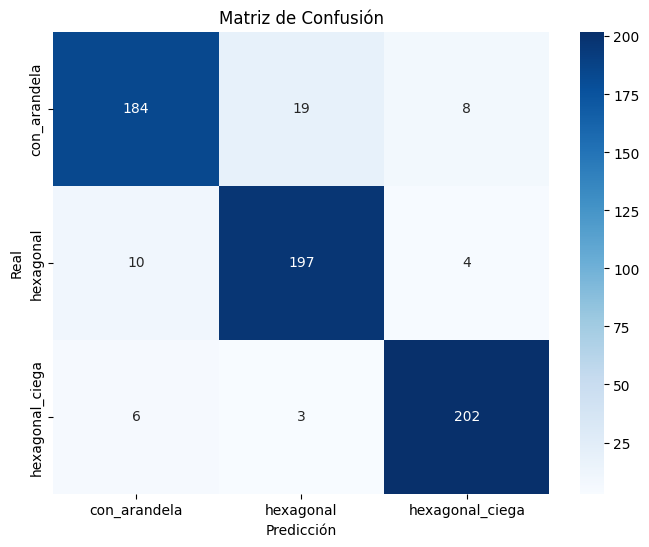

In [19]:
# Generar matriz de confusión
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


## **Predicciones con la RNAC entrenada.**

En esta sección se hacen pruebas para verificar la exactitud del modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


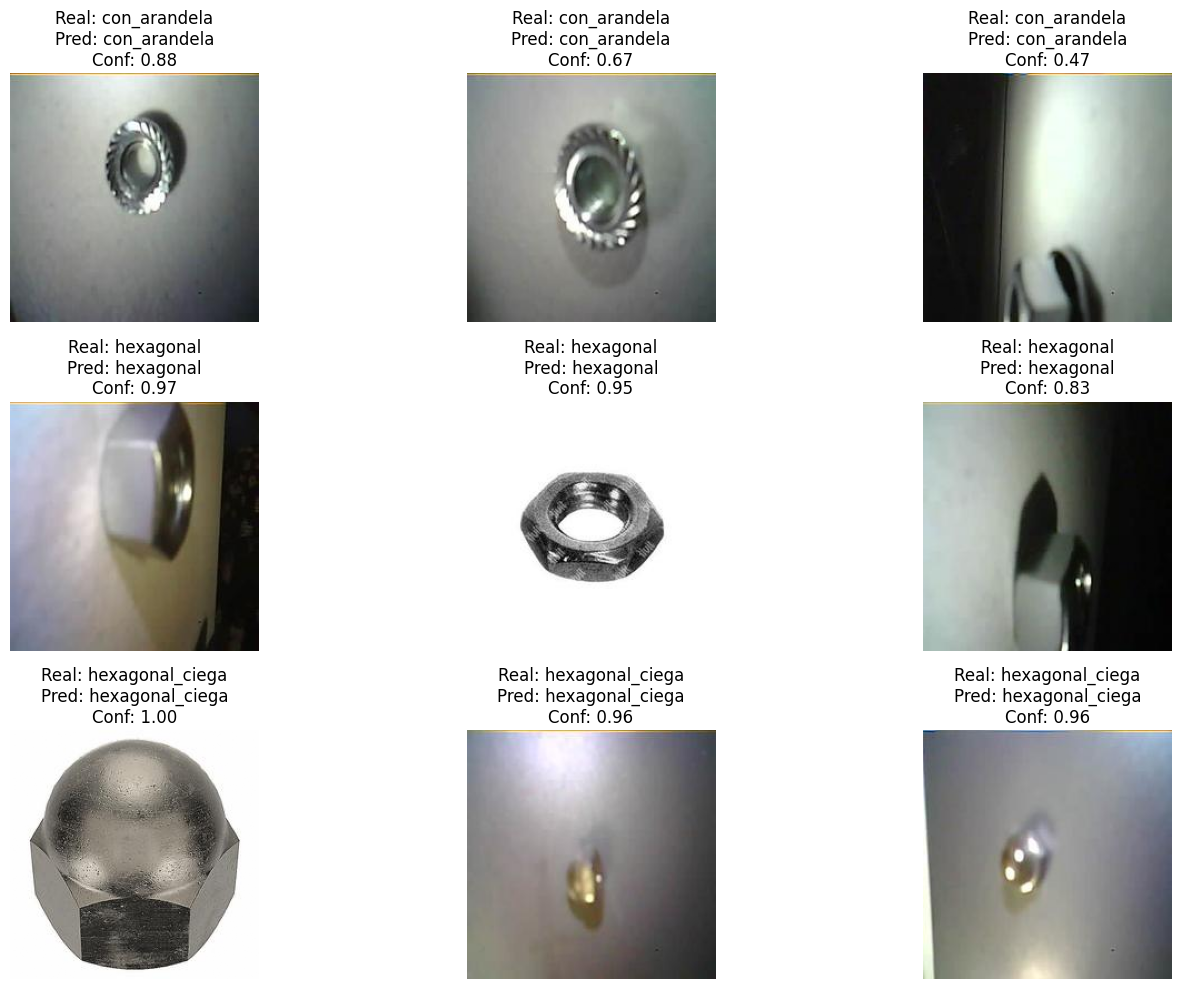

In [22]:
def prepare_image(img_path):
    # Cargar imagen para predicción
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array

def display_image(img_path):
    # Cargar imagen para visualización (sin preprocesamiento del modelo)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array / 255.0  # Normalizar a [0,1]

# Selección de muestras
num_images_to_predict = 3
plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(class_names):
    class_folder = os.path.join(DATASET_PATH, class_name)
    all_images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    try:
        selected_images = random.sample(all_images, min(num_images_to_predict, len(all_images)))
    except ValueError:
        selected_images = all_images

    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_folder, img_name)

        # Procesar para modelo y para visualización por separado
        img_preprocessed = prepare_image(img_path)
        img_display = display_image(img_path)

        # Hacer predicción
        prediction = model.predict(img_preprocessed[np.newaxis, ...])
        confidence = np.max(prediction)
        predicted_class = class_names[np.argmax(prediction)]

        # Mostrar imagen de visualización
        ax = plt.subplot(len(class_names), num_images_to_predict, idx * num_images_to_predict + i + 1)
        plt.imshow(img_display)
        plt.title(f"Real: {class_name}\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()